In [ ]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from IPython.display import clear_output
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import random
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, f1_score
import csv


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

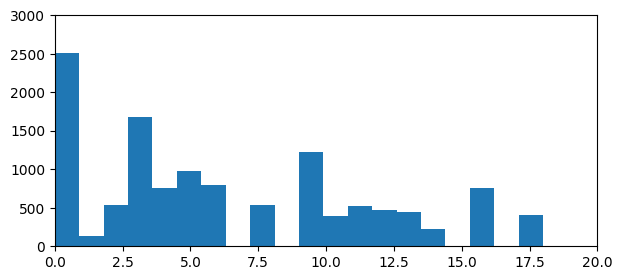

In [22]:
train_ans = pd.read_csv('human_poses_data/train_answers.csv')

plt.figure(figsize=(7, 3))
plt.axis((0, 20, 0, 3000))
# plt.xticks(np.arange(0, 20, 1.0))
plt.hist(train_ans['target_feature'].values, bins=20)
plt.show()

In [23]:
targets = list(train_ans['target_feature'].values)

for i in range(0, 21):
    print(f'{i} - {targets.count(i)}')

0 - 2512
1 - 135
2 - 530
3 - 1680
4 - 752
5 - 982
6 - 800
7 - 0
8 - 533
9 - 1223
10 - 390
11 - 528
12 - 469
13 - 442
14 - 228
15 - 0
16 - 753
17 - 0
18 - 410
19 - 0
20 - 0


In [24]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            self.label_map = label_map
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image

In [ ]:
transform = Compose([
    Resize((64, 64)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
    RandomAutocontrast(p=1.0),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)

train_set, valid_set = random_split(train_data, (0.9, 0.1))


In [26]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset, target_size=1000):
        self.original_dataset = original_dataset
        self.target_size = target_size
        self.class_indices = defaultdict(list)
        
        for i in range(len(original_dataset)):
            _, label = original_dataset[i]
            self.class_indices[label].append(i)
        
        self.samples = []
        
        for class_id, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count == 0:
                continue
                
            elif current_count < target_size:
                needed = target_size - current_count
                
                self.samples.extend([(idx, False) for idx in indices])
                
                aug_source_indices = np.random.choice(indices, size=needed, replace=True)
                self.samples.extend([(idx, True) for idx in aug_source_indices])
                
            elif current_count > target_size:
                selected_indices = random.sample(indices, target_size)
                self.samples.extend([(idx, False) for idx in selected_indices])
                
        self.aug_transform = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=10),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ])
        
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        original_idx, should_augment = self.samples[idx]
        image, label = self.original_dataset[original_idx]
        
        if should_augment:
            image = self.aug_transform(image)
            
        return image, label

balanced_train_set = BalancedDataset(train_set.dataset, 1000)


In [ ]:
BATCH_SIZE = 128

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (32, 64, 64)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (128, 16, 16)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (256, 8, 8)

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),  # (384, 8, 8)
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (384, 4, 4)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=1),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (512, 2, 2)

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),  # (1024, 2, 2)
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (1024, 1, 1)
        )



        self.skip1 = nn.Sequential(  # (32, 64, 64)
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),  # (128, 64, 64)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (128, 16, 16)
        )
        
        self.skip2 = nn.Sequential(  # (384, 4, 4)
            nn.Conv2d(384, 1024, kernel_size=3, stride=2, padding=1),  # (1024, 2, 2)
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (1024, 1, 1)
        )


        self.classifier = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 20)
        )

    def forward(self, x):
        x = self.block1(x)
        skip = self.skip1(x)
        out = self.block2(x)

        x = self.block3(skip + out)
        skip = self.skip2(x)
        out = self.block4(x)

        x = skip + out
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [29]:
model = Model2().to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]          36,992
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

In [30]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    acc = 0
    f1 = 0
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            else:
                y = y.cpu().numpy()
                pred = pred.argmax(dim=1).cpu().numpy()
                acc += accuracy_score(y, pred)
                f1 += f1_score(y, pred, average='macro')

            
    length = len(dataloader)
    return total_loss / length, acc / length, f1 / length

In [32]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

In [33]:
# from sklearn.metrics import accuracy_score, f1_score

# NUM_EPOCHS = 50

# #  Обучение модели
# model = Model2().to(device)

# loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), 
#                            lr=0.0005,
#                            weight_decay=1e-4)


# train_loss_hist = []
# test_loss_hist = []
# accuracy = []
# f1 = []

# for i in range(NUM_EPOCHS):

#     train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
#     train_loss_hist.append(train_loss)

#     test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
#     test_loss_hist.append(test_loss)

#     accuracy.append(acc)
#     f1.append(f1_)

#     if f1[-1] == max(f1):
#         torch.save(model, 'model2_best_model.pth')
#         torch.save(model.state_dict(), 'model2_best_weights.pth')

#     show_losses(train_loss_hist, test_loss_hist, accuracy, f1)



# print(f"Min loss: {min(test_loss_hist):6>}")
# print(f"Max Accuracy: {max(accuracy)}")
# print(f"Max F1: {max(f1)}")

In [34]:
# import torch
# torch.cuda.empty_cache()  

In [35]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 32, 32)
        )



        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 16, 16)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 8, 8)
        )
        # --------------skip1--------------



        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 4, 4)
        )


        # --------------skip2--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 2, 2)
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 2, 2)
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (256, 1, 1)
        )
        # --------------skip2--------------



        self.skip1 = nn.Sequential(  # (32, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 8, 8)
        )
        
        self.skip2 = nn.Sequential(  # (128, 4, 4)
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 2, 2) 
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 1, 1)
        )


        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 20)
        )

    def forward(self, x):
        x = self.block1(x)
        skip = self.skip1(x)
        out = self.block2(x)

        x = self.block3(skip + out)
        skip = self.skip2(x)
        out = self.block4(x)

        x = skip + out
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [36]:
model = Model3().to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             PReLU-3           [-1, 32, 64, 64]               1
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
             PReLU-7           [-1, 64, 16, 16]               1
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
            PReLU-11           [-1, 32, 32, 32]               1
        MaxPool2d-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,496
      BatchNorm2d-14           [-1, 64,

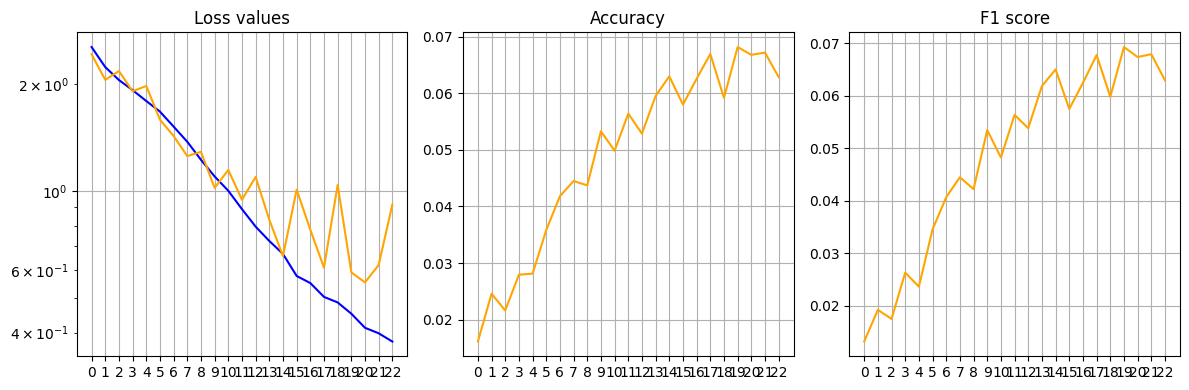

  1%|          | 1/125 [00:03<07:34,  3.67s/it]


KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS = 50

#  Обучение модели
model = Model3().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-5
                           )


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):

    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)

    if f1[-1] == max(f1):
        torch.save(model, 'model3_best_model.pth')
        torch.save(model.state_dict(), 'model3_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)



print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

In [1]:
print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

NameError: name 'test_loss_hist' is not defined

In [38]:
model = torch.load('model3_best_model.pth', weights_only=False)

In [ ]:
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for img_name in tqdm(test_set.image_files):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image)
        
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])
        test_preds.append(pred.item())

test_ids, test_preds = zip(*sorted(zip(test_ids, test_preds), key=lambda x: int(x[0])))

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['ID', 'target_feature'])
    writer.writerows(zip(test_ids, test_preds))


100%|██████████| 5301/5301 [01:31<00:00, 57.93it/s]
